In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


In [2]:
Image_Size=256
Batch_Size=32
Epochs=50
Channels=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("./potato_disease/PlantVillage",
batch_size=Batch_Size,
image_size=(Image_Size,Image_Size),
shuffle=True)

Found 2152 files belonging to 3 classes.


In [4]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):#dataset.take(n)--->n of batch
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 1 1 1 1 1 0 1 1 1 1 0 0 2 1 0 0 0 0 0 1 0 0 1 1 0 1 2 0 1 0 1]


In [6]:
# transformation
data_augumentation=tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical")])

<!-- 3 is for rgb  -->

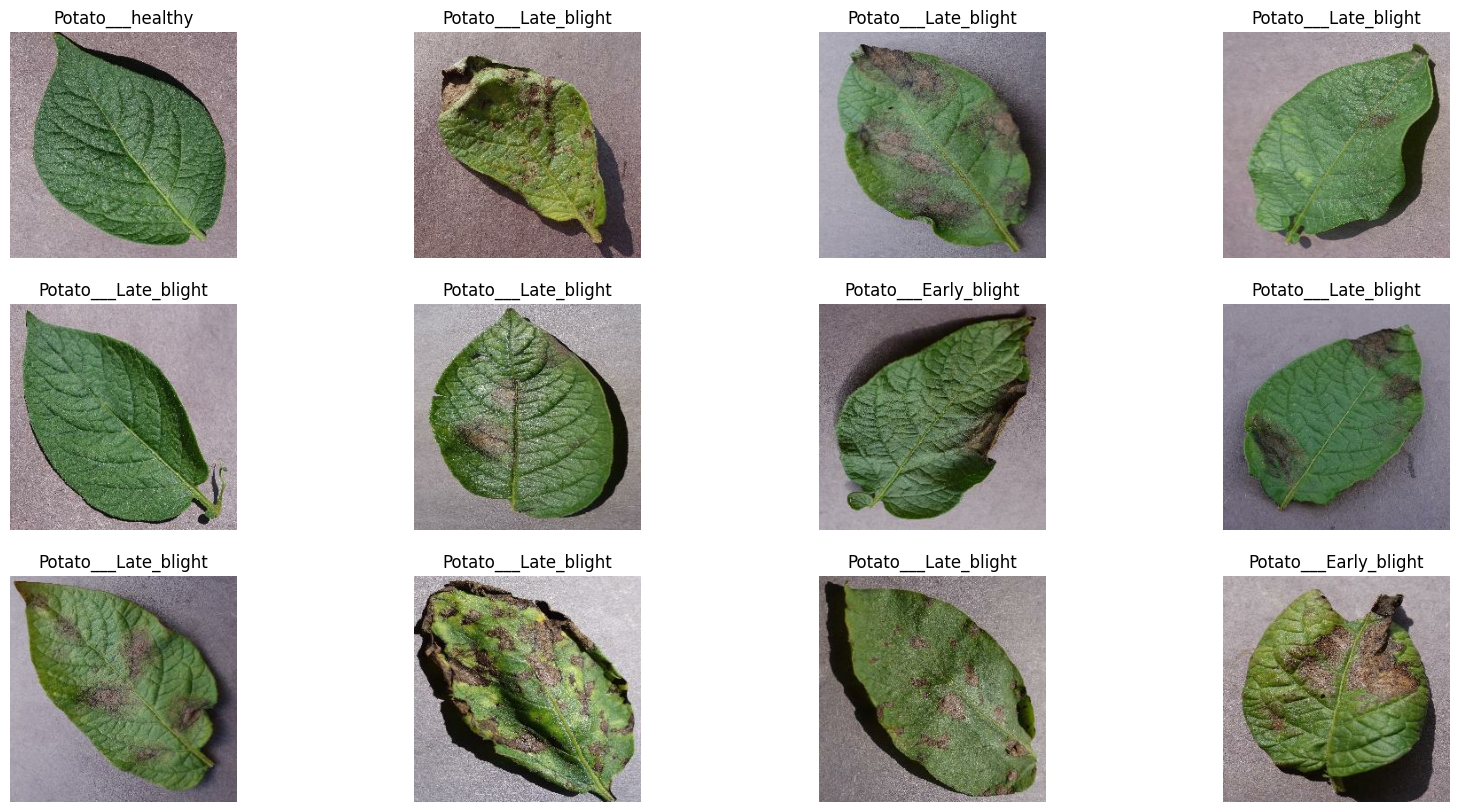

In [7]:
plt.figure(figsize=(20,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis('off')

In [8]:
# train_data=dataset.take(54)
# test_data=dataset.skip(54)

In [9]:
# val_data=test_data.take(6)
# test_ds=test_data.skip(6)

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        assert (train_split + test_split + val_split) == 1

        ds_size=len(ds)#68
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        train_size=int(train_split*ds_size)#0.8*68=54
        val_size=int(val_split*ds_size)#0.1*68=6
        train_ds = ds.take(train_size) #54
        val_ds = ds.skip(train_size).take(val_size)#it will skip 54 and take 6
        test_ds = ds.skip(train_size).skip(val_size)#it will skip 54 and skip  6 and take 8
        return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
print(f"Test df length: {len(test_ds)} \nTrain df length: {len(train_ds)} \nValidation df length: {len(val_ds)}")

Test df length: 8 
Train df length: 54 
Validation df length: 6


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_Size, Image_Size),
  layers.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.2),
#     layers.RandomBrightness(0.2),
#     layers.RandomTranslation(0.2, 0.2),
    # Add more data augmentation layers as needed
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
input_shape = (Image_Size, Image_Size, Channels)
batch_input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
n_classes=3
batch_input_shape

(32, 256, 256, 3)

In [18]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs,
)

Epoch 1/50
54/54 [==============================] - 95s 2s/step - loss: 0.8882 - accuracy: 0.5017 - val_loss: 0.7876 - val_accuracy: 0.5260
Epoch 2/50
54/54 [==============================] - 78s 1s/step - loss: 0.6935 - accuracy: 0.6620 - val_loss: 0.4887 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 83s 2s/step - loss: 0.5318 - accuracy: 0.7465 - val_loss: 0.3969 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 77s 1s/step - loss: 0.4001 - accuracy: 0.8351 - val_loss: 0.3061 - val_accuracy: 0.8542
Epoch 5/50
54/54 [==============================] - 82s 2s/step - loss: 0.3107 - accuracy: 0.8773 - val_loss: 0.3850 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 82s 2s/step - loss: 0.2465 - accuracy: 0.8999 - val_loss: 0.1753 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 78s 1s/step - loss: 0.1934 - accuracy: 0.9225 - val_loss: 0.1705 - val_accuracy: 0.9271
Epoch 8/50
54/54 [==

In [22]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 5s 259ms/step - loss: 0.0628 - accuracy: 0.9805


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

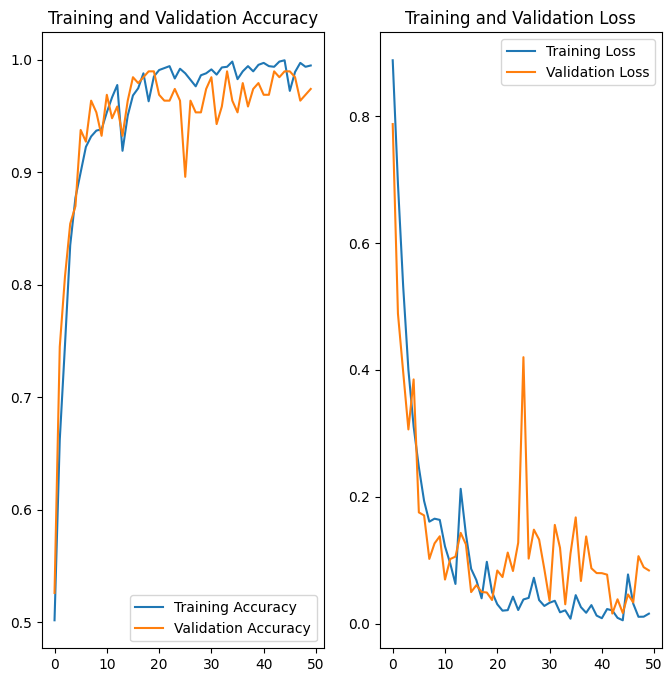

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(Epochs), loss, label='Training Loss')
plt.plot(range(Epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


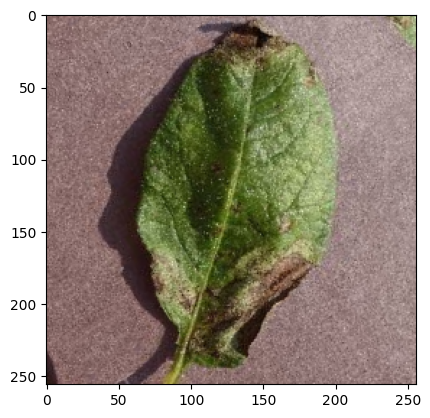

In [25]:
for images_batch, labels_batch in train_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


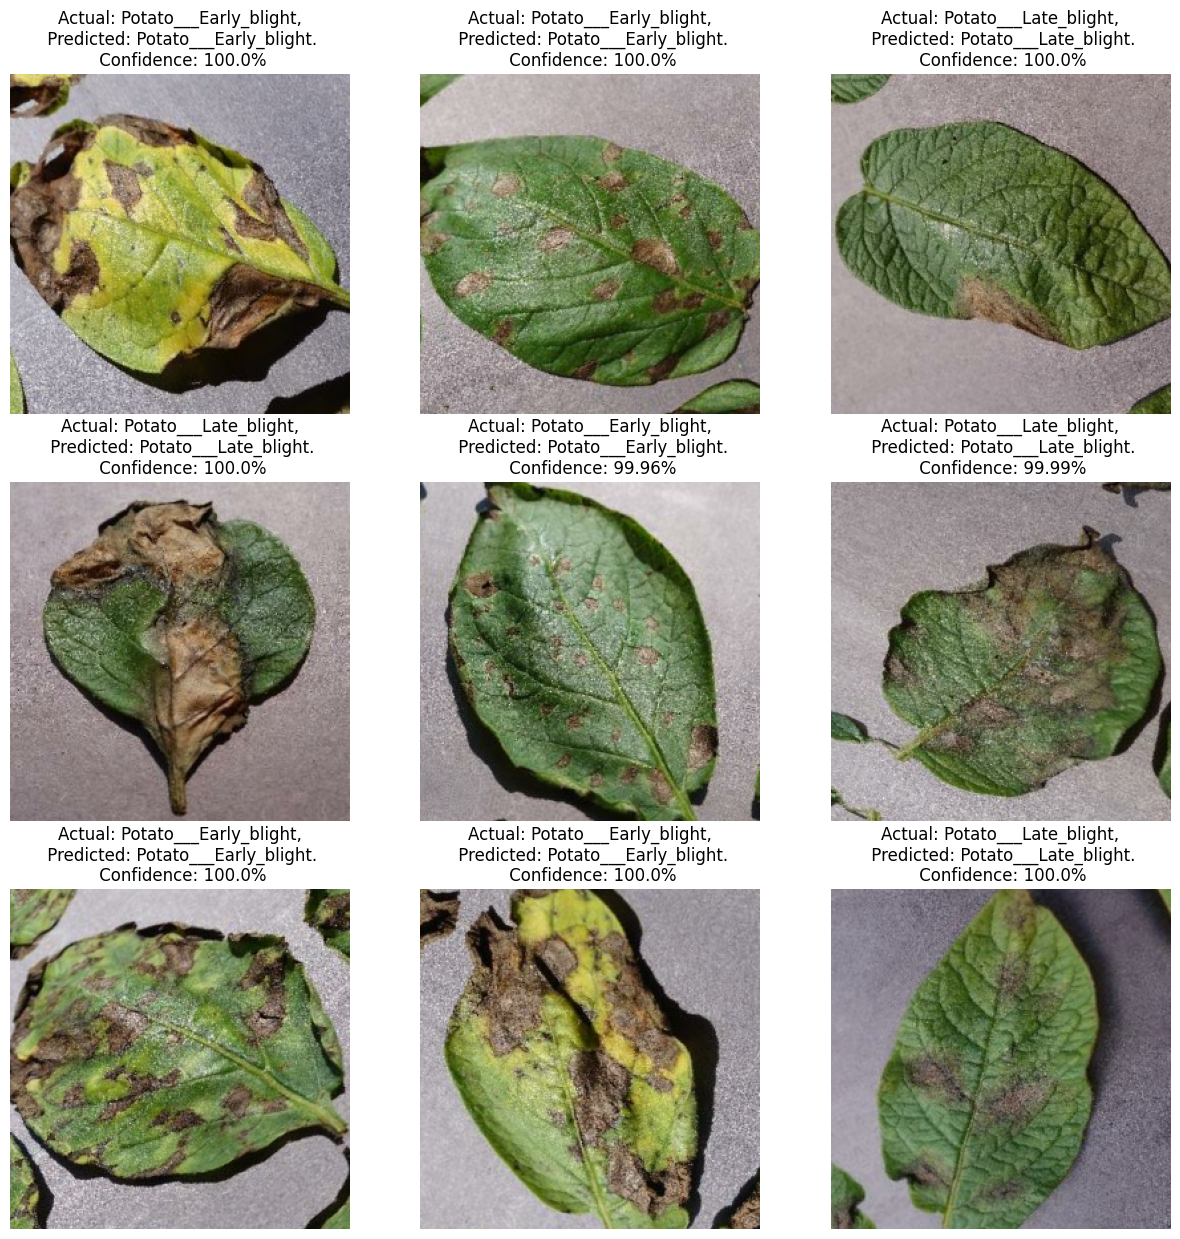

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 31ms/step


('Potato___healthy',
 100.0,
 array([[3.560171e-08, 8.545808e-06, 9.999914e-01]], dtype=float32))

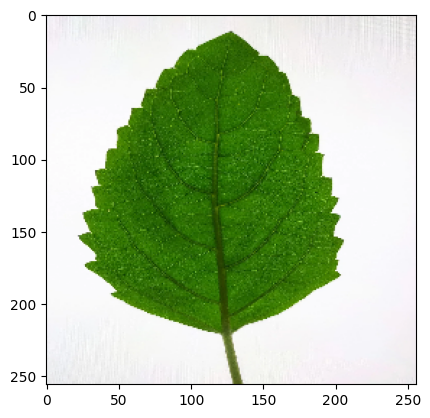

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt

img_path = r"C:\Users\Parth Dedhia\OneDrive - vit.ac.in\Pictures\healthy1.jpg"
# Load and resize the image
desired_height = 256
desired_width = 256
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(desired_height, desired_width))
plt.imshow(img)

# Convert image to numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)
predicted_class = class_name[np.argmax(predictions[0])]
confidence = round(100 * (np.max(predictions[0])), 2)

predicted_class, confidence,predictions


In [39]:
model.save("model.h5")